In [1]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader


def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.from_numpy(Rx[t:t+Ntest]), torch.from_numpy(Tx[t:t+Ntest]))['Qsq']))
    return Q

# with h5py.File('dataset_A800/train.h5', 'r') as f:
#     for key in f.keys():
#         print('Nch, Rs, Pch, symbs, NF, SF, L:', f[key].attrs['Nch'], f[key].attrs['Rs(GHz)'], f[key].attrs['Pch(dBm)'], f[key]['SymbTx'].shape[1], f[key].attrs['NF(dB)'], f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'], f[key].attrs['distance(km)'])

# 1. DDLMS

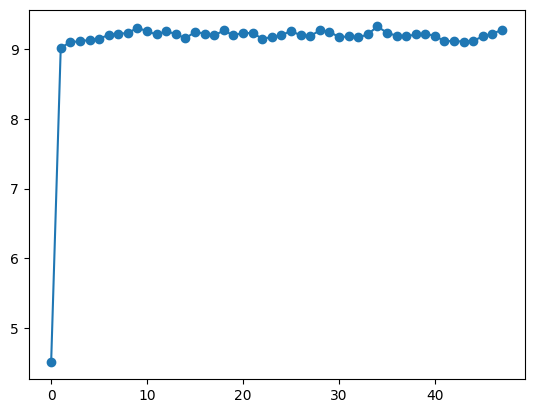

In [3]:
with h5py.File('dataset_A800/test.h5', 'r') as f:
    grp = get_grp(f, 11, 80, 3, 500000, 4.5, 1.2, 2000)
    Q1 = Q_path(grp['Rx_DBP64DDLMS(taps=32,lr=[0.015625, 0.0078125])'][0], grp['Tx'][0,7:-8], Ntest=20000)
plt.plot(Q1, '-o')
# plt.ylim(8, 10)

In [94]:
test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                      window_size=100000, strides=1, Nwindow=1, truncate=20000,
                      Tx_window=True, pre_transform='Rx_DBP64DDLMS(taps=32,lr=[0.015625, 0.0078125])')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

for Rx, Tx,info in test_loader:
    Rx = Rx.to(torch.complex64).to('cpu')
    Tx = Tx.to('cpu')
    break

BER(Rx, Tx)

{'BER': array([[0.0024875, 0.0027075]], dtype=float32),
 'SER': array([[0.00991, 0.01083]], dtype=float32),
 'Qsq': array([[8.969947, 8.884801]], dtype=float32),
 'SNR': array([[15.810142, 15.798846]], dtype=float32)}

# 2. static filter

In [95]:
train_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                       window_size=1000, strides=1, Nwindow=100, truncate=0,
                       Tx_window=True, pre_transform='Rx_DBP64')
train_loader = DataLoader(train_data, batch_size=10, shuffle=False)

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                      window_size=100000, strides=1, Nwindow=1, truncate=100000,
                      Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
print(len(train_loader))


def test_model(net, test_loader, device):
    for Rx, Tx,info in test_loader:
        Rx = Rx.transpose(1,2).to(torch.complex64).to(device)
        Tx = Tx.to(device)
        break
    with torch.no_grad():
        y = net(Rx).transpose(1,2)
        y0 = Tx

    return Qsq(np.mean(BER(y, y0)['BER']))

10


In [96]:
from src.TorchDSP.layers import ComplexConv1d, ComplexLinear

net = ComplexConv1d(2, 2, 2, stride=2)
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.1)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
net = net.to(device)
Q_list = []

for epoch in range(40):
    train_loss = 0
    for Rx, Tx,info in train_loader:
        Rx = Rx.transpose(1,2).to(torch.complex64).to(device)
        Tx = Tx.to(device)
        

        y = net(Rx).transpose(1,2)
        y0 = Tx[:,:,:]
        loss = torch.mean(torch.abs(y - y0)**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_loss = train_loss + loss.item()

    Q_test = test_model(net, test_loader, device)
    Q_list.append(Q_test)

    if epoch % 5 == 0:
        print('Epoch:', epoch, 'Loss:', train_loss/len(train_loader))
        print('Q:', Q_test)

Epoch: 0 Loss: 0.5770822472870349
Q: 4.754471385186429
Epoch: 5 Loss: 0.030981875583529474
Q: 7.846164471147279
Epoch: 10 Loss: 0.028400434367358684
Q: 7.9424619788488195
Epoch: 15 Loss: 0.02837971430271864
Q: 7.922464820040629
Epoch: 20 Loss: 0.02836697343736887
Q: 7.946146105869451
Epoch: 25 Loss: 0.02835522536188364
Q: 7.973916586123115
Epoch: 30 Loss: 0.028359156101942062
Q: 7.975417536852567
Epoch: 35 Loss: 0.028362863324582578
Q: 7.964939370961495


In [97]:
Q2 = []


for  t in np.arange(0, 480000, 10000):

    test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=20000, strides=1, Nwindow=1, truncate=t,
                        Tx_window=True, pre_transform='Rx_DBP64')
    test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

    Q2.append(test_model(net, test_loader, device))

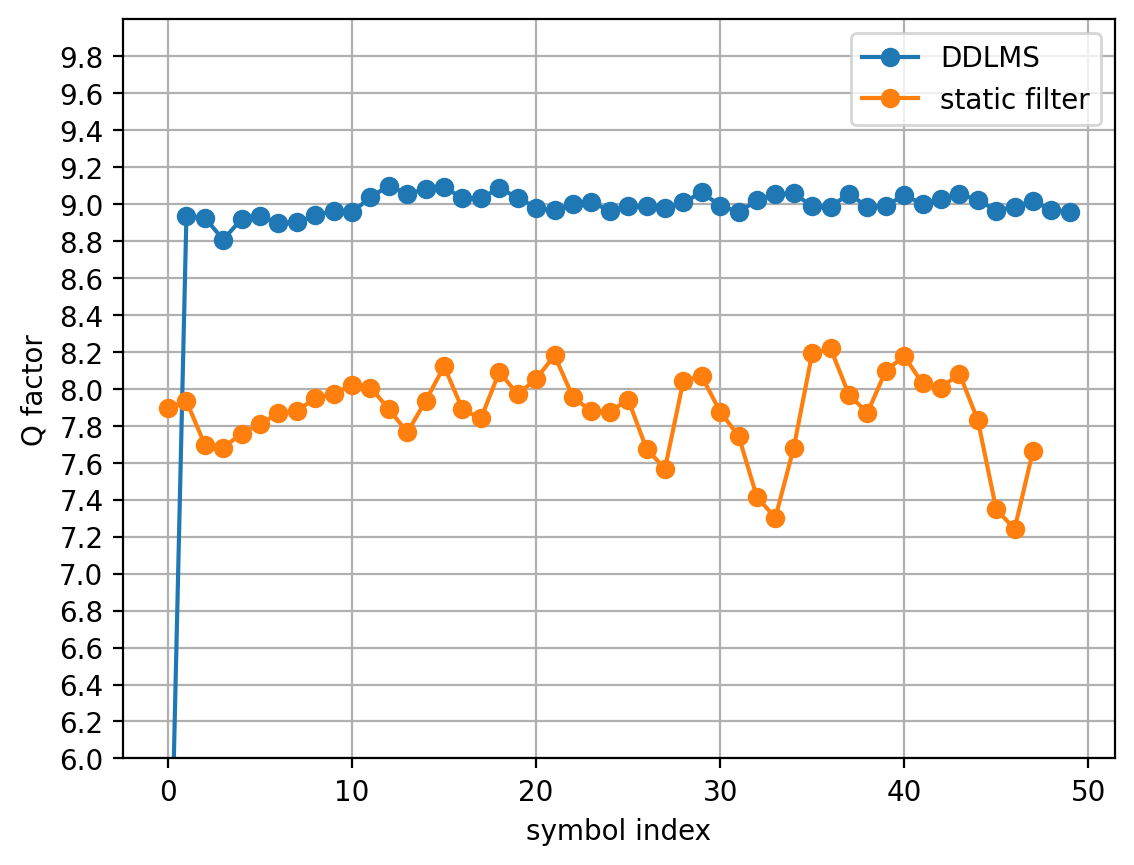

In [98]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 3. BPS

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


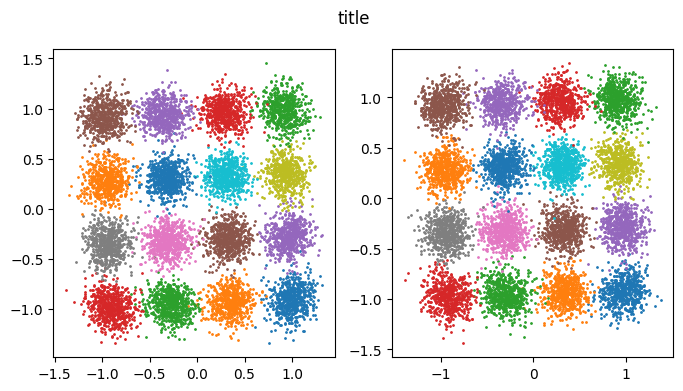

In [107]:
from src.JaxSimulation.dsp import BPS, bps, ddpll

test_data = MyDataset('dataset_A800/test.h5', Nch=[11], Rs=[80], Pch=[3],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

ax = show_symb(Rx[0,0::2][0:10000], Tx[0][0:10000], s=1)

array([<Axes: >, <Axes: >], dtype=object)

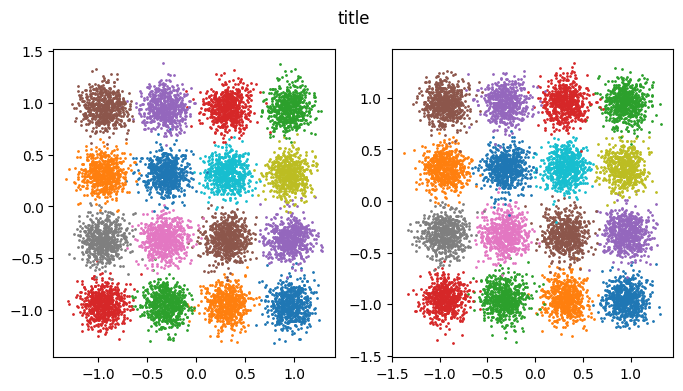

In [11]:
import jax
z, phase, _ = bps(Rx[0,::2].numpy(), 40, const, 161)
Tx_bps = jax.device_get(z)
show_symb(Tx_bps[0:10000], Tx[0].numpy()[0:10000], s=1)

Text(0.5, 1.0, 'Phase Noise')

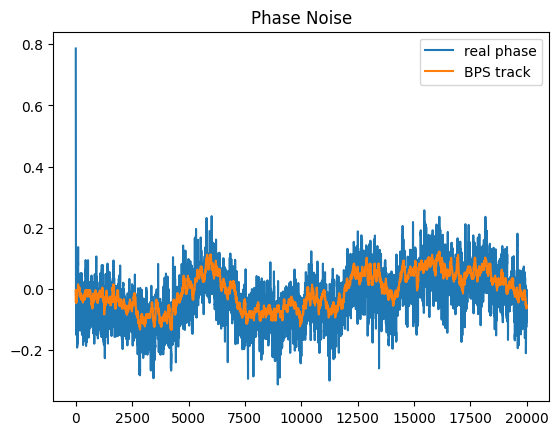

In [22]:
real_phase = - np.angle(Rx[0,::2].numpy() / Tx[0].numpy())
taps = 10
real_phase = np.convolve(real_phase[:,0], np.ones(taps)/taps, mode='same') + 1.55

plt.plot(real_phase[0:20000], label='real phase')
plt.plot(phase[0:20000,0], label='BPS track')
plt.legend()
plt.title('Phase Noise')

# 3.5 Real noise compare

In [108]:
def get_noise(Nch, Rs, Pch, taps=100):
    test_data = MyDataset('dataset_A800/test.h5', Nch=[Nch], Rs=[Rs], Pch=[Pch],Nmodes=2,
                            window_size=500000, strides=1, Nwindow=1, truncate=0,
                            Tx_window=True, pre_transform='Rx_DBP64')
    test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
    for Rx, Tx, info in test_loader:
        # print(Rx.shape, Tx.shape, info.shape)
        break
    real_phase = - np.angle(Rx[0,::2].numpy() / Tx[0].numpy())
    real_phase = real_phase - np.mean(real_phase)
    return np.unwrap(np.convolve(real_phase[:,0], np.ones(taps)/taps, mode='valid'))

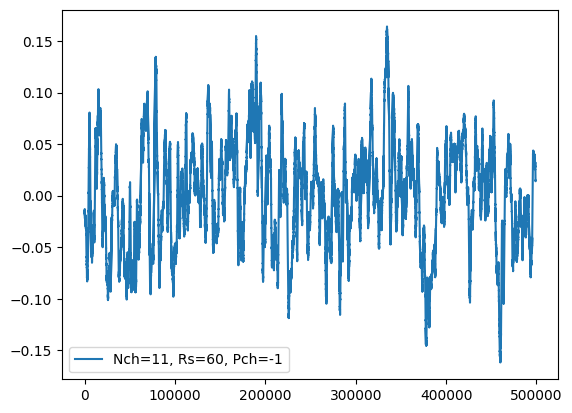

In [115]:
plt.plot(get_noise(11, 80, 3, taps=1000), label='Nch=11, Rs=60, Pch=-1')
# plt.plot(get_noise(21, 80, 3, taps=10000), label='Nch=21, Rs=60, Pch=-1')
plt.legend()

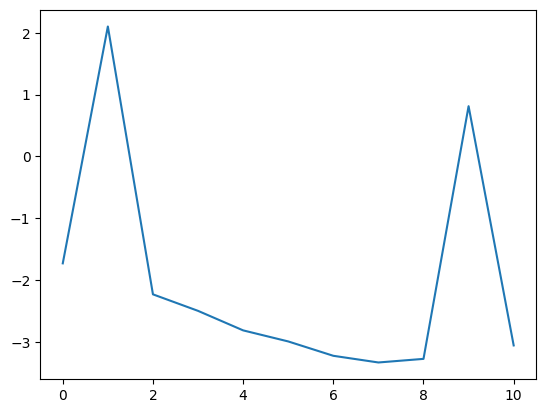

In [67]:
plt.plot([np.log(np.var(get_noise(21, 160, p, taps=1))) for p in range(-3, 8)])

In [10]:
import jax
Tx_bps = jax.device_get(z)
Q3 = Q_path(Tx_bps, Tx[0].numpy(), Ntest=20000)

/tmp/ipykernel_879469/153927121.py:24: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  Q.append(np.mean(BER(torch.from_numpy(Rx[t:t+Ntest]), torch.from_numpy(Tx[t:t+Ntest]))['Qsq']))


In [ ]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 4. DDPLL

In [104]:
from src.JaxSimulation.dsp import BPS, bps, ddpll

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


The best Kv =  0.006
(500000, 2) (500000, 2)


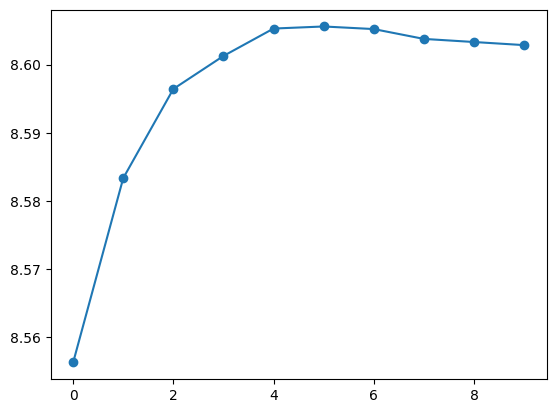

In [105]:
import jax
Qs = []

xis = np.linspace(0.001, 0.01, 10)
for Kv in xis:
    z, phase, _ = ddpll(Rx[0,::2].numpy(), Kv, const, Tx[0].numpy())
    Tx_ddpll = jax.device_get(z)
    Qs.append(Qsq(BER(torch.from_numpy(Tx_ddpll), Tx[0])['BER'].mean()))

plt.plot(Qs, '-o')
Kv = xis[np.argmax(Qs)]

print('The best Kv = ', Kv)
z, phase, _ = ddpll(Rx[0,::2].numpy(), Kv, const, Tx[0].numpy())
Tx_ddpll = jax.device_get(z)
print(z.shape, phase.shape)

In [106]:
Q4 = Q_path(Tx_ddpll, Tx[0].numpy(), Ntest=20000)

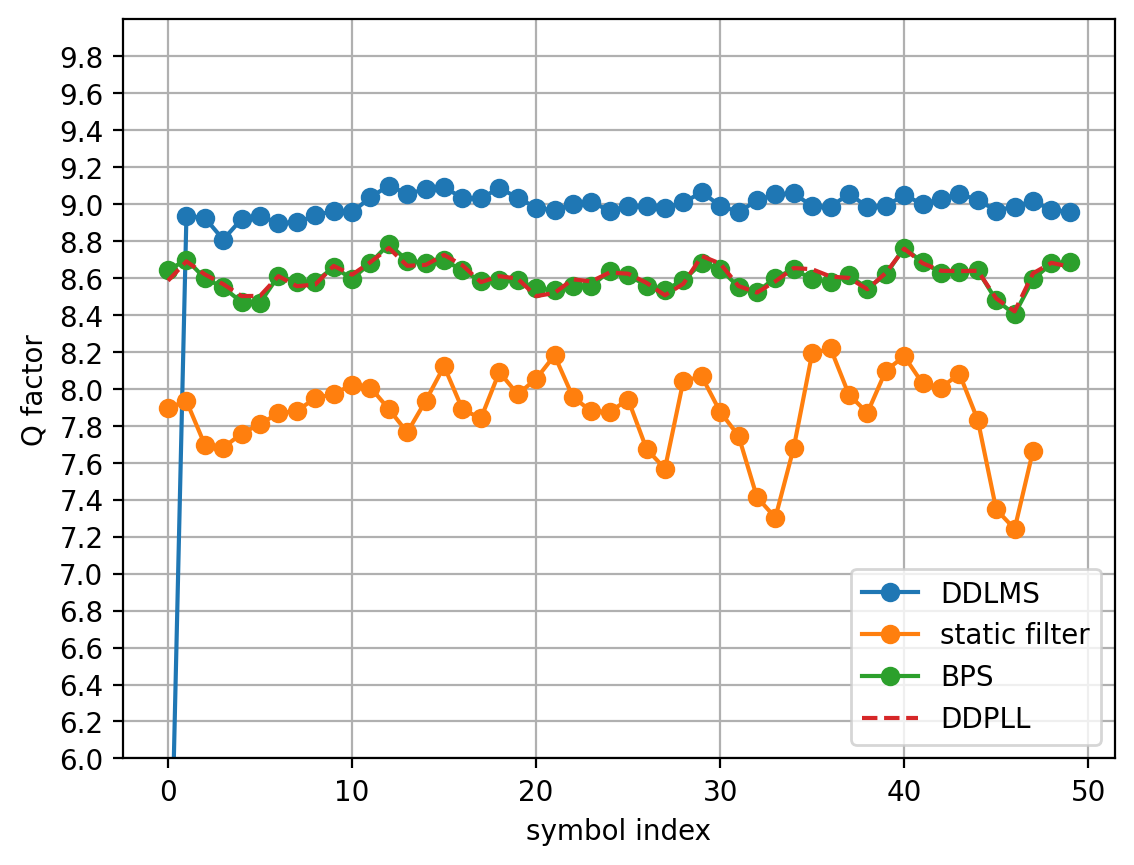

In [107]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.plot(Q4, '--', label='DDPLL')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 5. CPR

In [108]:
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[80], Pch=[2],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP64')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


In [109]:
import jax.numpy as jnp
z, phase, _ = cpr(jnp.array(Rx[0,::2].numpy()), 60, jnp.array(const), jnp.array(Tx[0].numpy()))
Tx_cpr = jax.device_get(z)
print(z.shape, phase.shape)

(500000, 2) (500000, 2)


array([<Axes: >, <Axes: >], dtype=object)

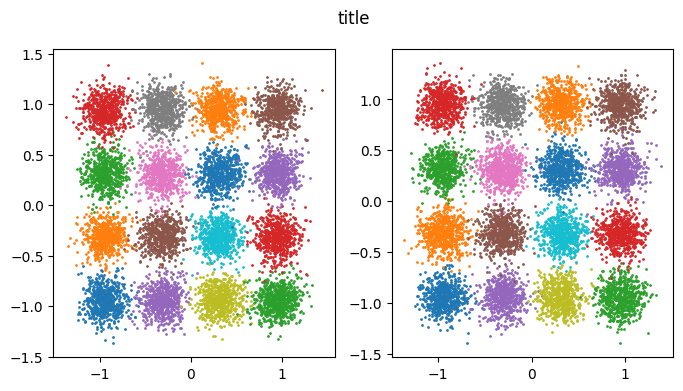

In [110]:
show_symb(Tx_cpr[0:10000], Tx[0].numpy()[0:10000], s=1)

In [111]:
Q5 = Q_path(Tx_cpr, Tx[0].numpy(), Ntest=20000)

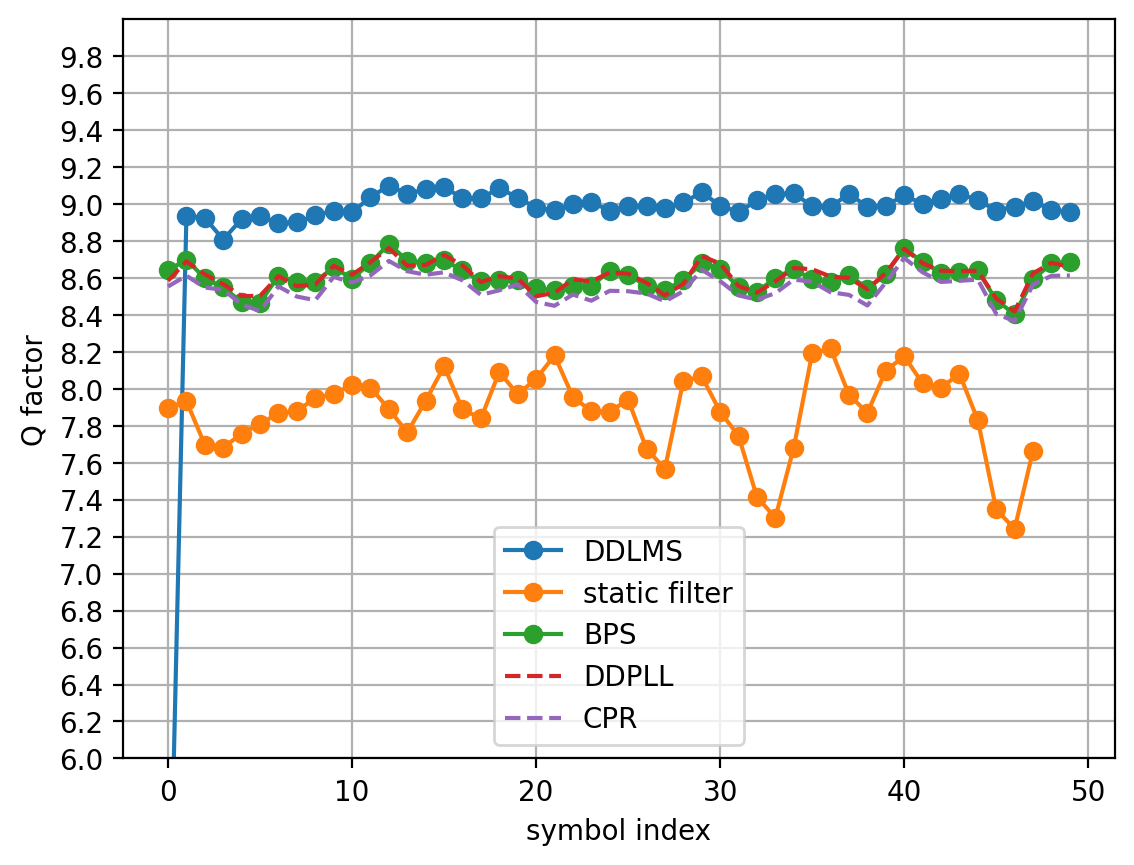

In [112]:
plt.figure(dpi=200)
plt.plot(Q1, '-o', label='DDLMS')
plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.plot(Q4, '--', label='DDPLL')
plt.plot(Q5, '--', label='CPR')
plt.legend()

plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 6. MIMOAF: af.ddlms, af.lms

In [7]:
import numpy as np, jax
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af
from src.JaxSimulation.core import MySignal, SigTime
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader

test_data = MyDataset('dataset_A800/test.h5', Nch=[11], Rs=[80], Pch=[3],Nmodes=2,
                        window_size=500000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP8')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

torch.Size([1, 1000000, 2]) torch.Size([1, 500000, 2]) torch.Size([1, 4])


In [ ]:
Q_ddlms = {}

for taps in [64, 32, 16, 8, 4]:
    model = mimoaf(taps=taps, train=lambda n: n<2000, mimofn=af.ddlms, learnable=False)
    z, state = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
    Tx_ddlms = jax.device_get(z.val)

    Q_ddlms[f'DDLMS taps={taps}'] = Q_path(Tx_ddlms, Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000)

: 

In [197]:
Q_lms = {}

for taps in [64, 32, 16, 8, 4]:
    model = mimoaf(taps=taps, train=lambda n: n<10000, mimofn=af.lms, learnable=False)
    z, state = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
    Tx_ddlms = jax.device_get(z.val)

    Q_lms[f'LMS taps={taps}'] = Q_path(Tx_ddlms, Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000)

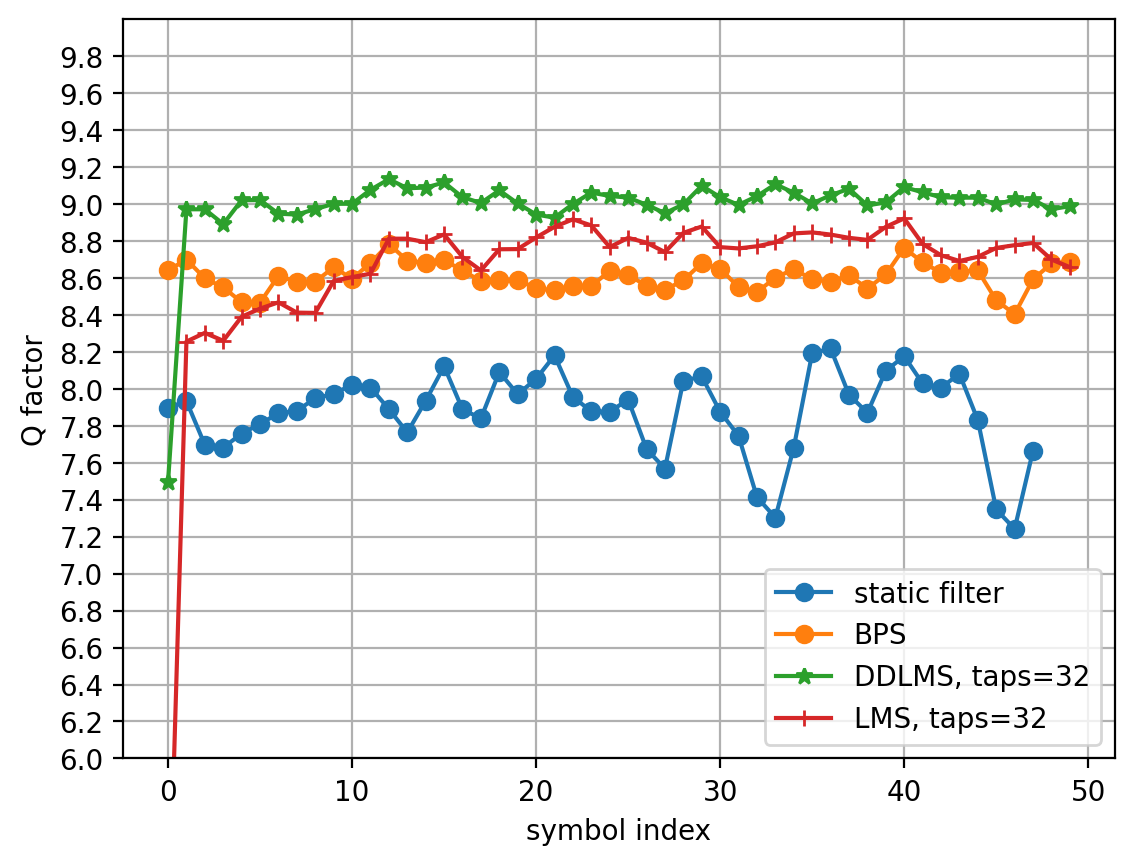

In [199]:
plt.figure(dpi=200)
# plt.plot(Q2, '-o', label='static filter')
# plt.plot(Q3, '--', label='BPS')
# plt.plot(Q4, '--', label='DDPLL')
# plt.plot(Q5, '--', label='CPR')
# for key in Q_ddlms.keys():
#     plt.plot(Q_ddlms[key], '-*', label=key)
# for key in Q_lms.keys():
#     plt.plot(Q_lms[key], '-*', label=key)


plt.plot(Q2, '-o', label='static filter')
plt.plot(Q3, '-o', label='BPS')
plt.plot(Q_ddlms['DDLMS taps=32'], '-*', label='DDLMS, taps=32')
plt.plot(Q_lms['LMS taps=32'], '-+', label='LMS, taps=32')

plt.legend()
plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 7. DDLMS, change lr

In [2]:
import numpy as np
from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader


test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0], Nmodes=2,
                        window_size=200000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP2')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

Q_ddlms = {}

for lr in [-3, -4, -5, -6, -7, -8, -9]:
    model = mimoaf(taps=32, train=lambda n: n<2000, mimofn=af.ddlms, learnable=False, mimokwargs={'lr_w':2**lr, 'lr_f':2**lr})
    adf = jax.jit(model.init_with_output, backend='cpu', static_argnums=(3))
    z, state = adf(jax.random.PRNGKey(0), signal, truth, True)
    Tx_ddlms = jax.device_get(z.val)

    Q_ddlms[f'DDLMS lr=2^{lr}'] = Q_path(Tx_ddlms, Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=5000)

torch.Size([1, 400000, 2]) torch.Size([1, 200000, 2]) torch.Size([1, 4])


/tmp/ipykernel_2116542/2727856801.py:24: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at ../torch/csrc/utils/tensor_numpy.cpp:206.)
  Q.append(np.mean(BER(torch.from_numpy(Rx[t:t+Ntest]), torch.from_numpy(Tx[t:t+Ntest]))['Qsq']))


DDLMS lr=2^-3 7.1161246
DDLMS lr=2^-4 7.7473636
DDLMS lr=2^-5 7.9342356
DDLMS lr=2^-6 7.9751925
DDLMS lr=2^-7 7.949257
DDLMS lr=2^-8 7.83908
DDLMS lr=2^-9 7.5976934


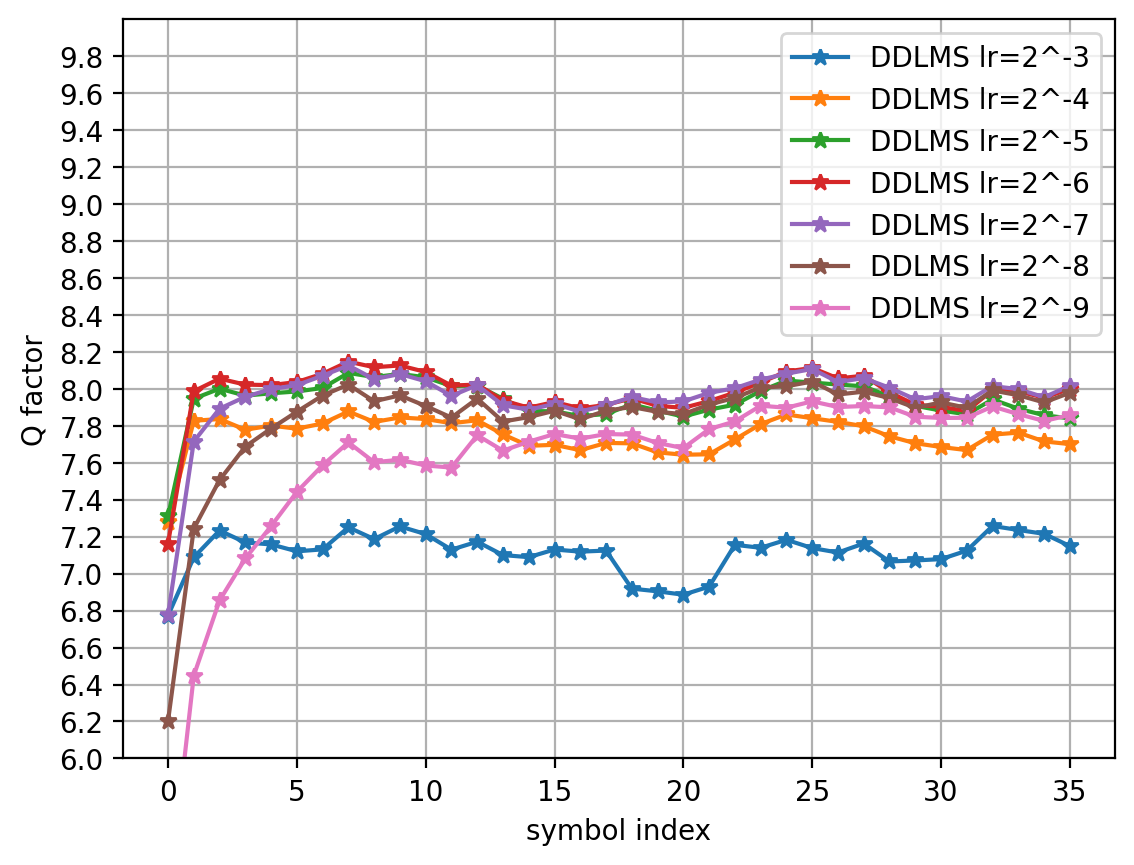

In [7]:
plt.figure(dpi=200)
for key in Q_ddlms.keys():
    plt.plot(Q_ddlms[key], '-*', label=key)
    print(key, np.mean(Q_ddlms[key]))

plt.legend()
plt.ylim(6, 10)
plt.yticks(np.arange(6, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# 7. Meta ADF

In [9]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader


def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))
    return Q

from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf, MetaMIMO
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.JaxSimulation.MetaOptimizer import *


test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0], Nmodes=2,
                        window_size=200000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

model = MetaMIMO(taps=32, train=lambda n: n<10000, MetaOpt=MetaNone(lr_init=(1/2**6, 0)))
z, params = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
Q_lms = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=10000, stride=10000)

model = MetaMIMO(taps=32, train=lambda n: n<10000, MetaOpt=MetaNone(lr_init=(1/2**6, 1/2**7)))
z, params = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
Q1 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=10000, stride=10000)


torch.Size([1, 400000, 2]) torch.Size([1, 200000, 2]) torch.Size([1, 4])


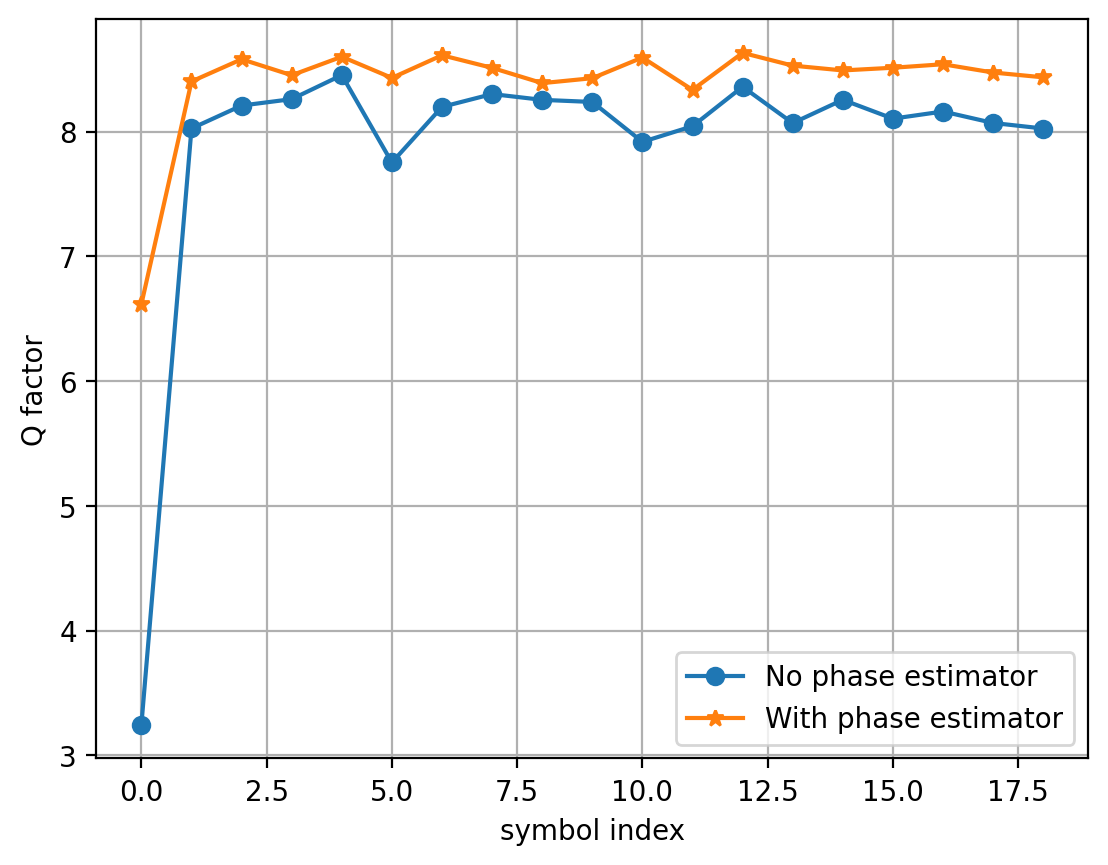

In [10]:
plt.figure(dpi=200)
plt.plot(Q_lms, '-o', label='No phase estimator')
plt.plot(Q1, '-*', label='With phase estimator')

plt.legend()
# plt.ylim(8, 10)
# plt.yticks(np.arange(8, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

## 7.1 MetaAdam

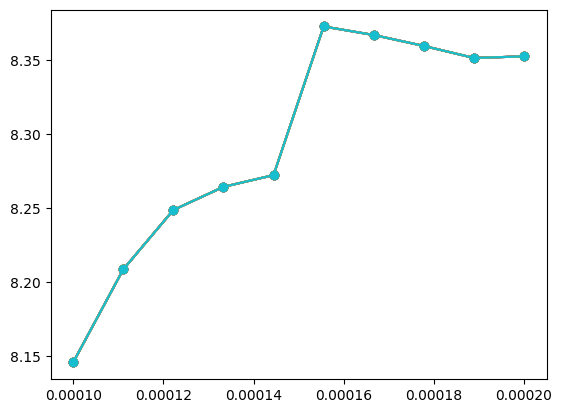

In [8]:
# model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaLSTMOpt_A(hidden_dim=2, depth=1))

Qs = []
for lr in np.linspace(1e-4, 2e-4, 10):
    model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaAdamOpt(learning_rate_init=lr))
    z, params = jax.jit(model.init_with_output, backend='cpu', static_argnums=3)(jax.random.PRNGKey(0), signal, truth, True)
    Qs.append(Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=5000))

# ax = show_symb(jax.device_get(z.val)[10000:20000], Tx[0,z.t.start:z.t.stop].numpy()[10000:20000], s=1)

for key in Qs:
    plt.plot(np.linspace(1e-4, 2e-4, 10), [np.mean(q[2:]) for q in Qs], '-o')

k = np.argmax([np.mean(q[2:]) for q in Qs])
lr  = np.linspace(1e-4, 2e-4, 10)[k]
Q2 = Qs[k]

In [13]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaAdamOpt(learning_rate_init=1.5e-4, b1_init=0.5, b2_init=0.6))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q3 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

In [15]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaAdaGradOpt(learning_rate_init=5e-2, initial_accumulator_value_init=0.1))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q4 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

In [17]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaRmspropOpt(learning_rate_init=1.5e-5, momentum_init=0.9, nesterov=False))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q5 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

In [13]:
model = MetaMIMO(taps=32, train=lambda n: n<2000, MetaOpt=MetaSGDOpt(learning_rate_init=1e-2, momentum_init=0.1))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)
Q6 = Q_path(jax.device_get(z.val), Tx[0,z.t.start:z.t.stop].numpy(), Ntest=20000, stride=10000)

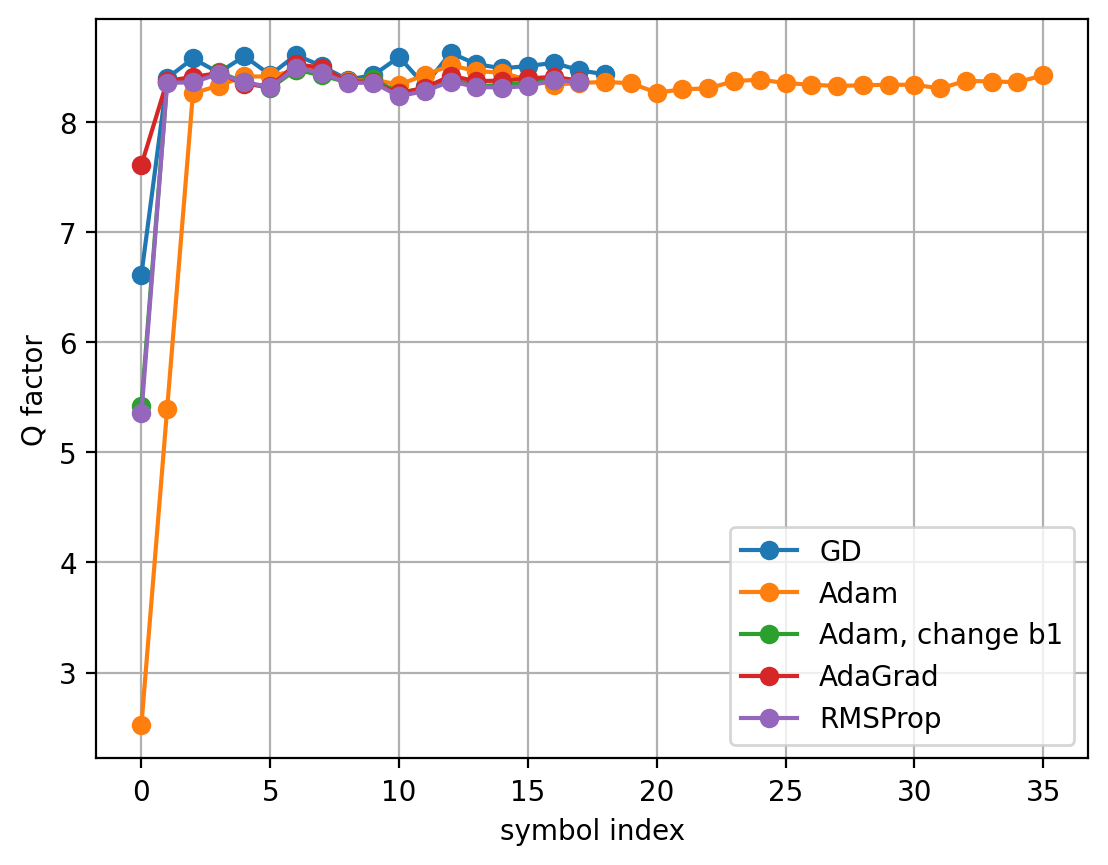

In [18]:
plt.figure(dpi=200)

plt.plot(Q1, '-o', label='GD')
plt.plot(Q2, '-o', label='Adam')
plt.plot(Q3, '-o', label='Adam, change b1')
plt.plot(Q4, '-o', label='AdaGrad')
plt.plot(Q5, '-o', label='RMSProp')
plt.legend()
# plt.ylim(8, 10)
# plt.yticks(np.arange(8, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

# Train Metaopt (Jax)

In [3]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader

import os 
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]='false'


def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))
    return Q

from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf, MetaMIMO
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.JaxSimulation.MetaOptimizer import *

train_data = MyDataset('dataset_A800/train.h5', Nch=[21], Rs=[40], Pch=[0, 1, 2], Nmodes=2,
                        window_size=400, strides=400-15, Nwindow=200, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)


test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0], Nmodes=2,
                        window_size=200000, strides=1, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=False)

for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
truth = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)

torch.Size([1, 400000, 2]) torch.Size([1, 200000, 2]) torch.Size([1, 4])


In [5]:
model = MetaMIMO(taps=32, train=True, MetaOpt=MetaGRUOpt(hidden_dim=2))
z, params = model.init_with_output(jax.random.PRNGKey(0), signal, truth, True)

from src.JaxSimulation.dsp import  construct_update
update_step = construct_update(model, optax.adam(1e-4), device='cpu', loss_type='MSE')
opt_state = optax.adam(1e-3).init(params['params'])
state_init = params['state']
state = params['state']
param = params['params']

TypeError: Cannot concatenate arrays with shapes that differ in dimensions other than the one being concatenated: concatenating along dimension 1 for shapes (130, 1), (4, 1).

In [19]:
Ls = []

for epoch in range(10):
    N = len(train_loader)
    ls = []
    for i,(Rx, Tx, info) in enumerate(train_loader):
        sig_input = MySignal(val=Rx[0].numpy(), t=SigTime(0,0,2), Fs=0)
        sig_output = MySignal(val=Tx[0].numpy(), t=SigTime(0,0,1), Fs=0)
        param, state, opt_state,l = update_step(param, state, opt_state, sig_input, sig_output)
        ls.append(l)
        print(f'Batch {i}/{N} loss:',l)
    Ls = Ls + ls
    print(f'epoch {epoch} train loss: {np.mean(ls)}')

Batch 0/10 loss: 0.029202746
Batch 1/10 loss: 0.028925179
Batch 2/10 loss: 0.0325022
Batch 3/10 loss: 0.028410086
Batch 4/10 loss: 0.030907357
Batch 5/10 loss: 0.032090094
Batch 6/10 loss: 0.02966362
Batch 7/10 loss: 0.03260489
Batch 8/10 loss: 0.028688522
Batch 9/10 loss: 0.031025477
epoch 0 train loss: 0.030402015894651413
Batch 0/10 loss: 0.030237785
Batch 1/10 loss: 0.029595273
Batch 2/10 loss: 0.030961465
Batch 3/10 loss: 0.03176349
Batch 4/10 loss: 0.03088912
Batch 5/10 loss: 0.034700014
Batch 6/10 loss: 0.03246878
Batch 7/10 loss: 0.033022705
Batch 8/10 loss: 0.034264866
Batch 9/10 loss: 0.032472767
epoch 1 train loss: 0.03203762322664261
Batch 0/10 loss: 0.029468006
Batch 1/10 loss: 0.034031603
Batch 2/10 loss: 0.029904565
Batch 3/10 loss: 0.030908525
Batch 4/10 loss: 0.033243418
Batch 5/10 loss: 0.030314501
Batch 6/10 loss: 0.031080889
Batch 7/10 loss: 0.029133327
Batch 8/10 loss: 0.029816419
Batch 9/10 loss: 0.032180496
epoch 2 train loss: 0.031008174642920494
Batch 0/10 loss

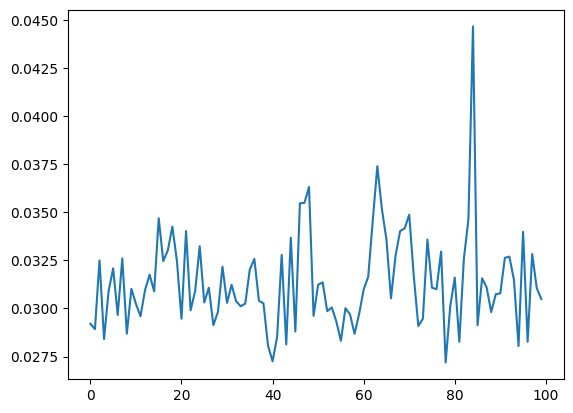

In [20]:
plt.plot(Ls)

In [61]:
model_test = MetaMIMO(taps=32, train=False, MetaOpt=MetaGRUOpt())

from functools import partial
@partial(jax.jit, backend='cpu')
def apply_model(var, signal, truth):
    return model_test.apply(var, signal, truth, True, mutable='state')

In [69]:
z, _ = apply_model({'params':param, 'state':state_init}, signal, truth)

In [70]:
BER(torch.tensor(jax.device_get(z.val))[20000:], torch.tensor(truth.val[7:-8])[20000:])

{'BER': array([0.00415173, 0.00410451], dtype=float32),
 'SER': array([0.01653471, 0.01631803], dtype=float32),
 'Qsq': array([8.430349, 8.443093], dtype=float32),
 'SNR': array([15.256648, 15.257649], dtype=float32)}

In [71]:
Q = Q_path(jax.device_get(z.val), truth.val[7:-8], Ntest=10000, stride=10000)

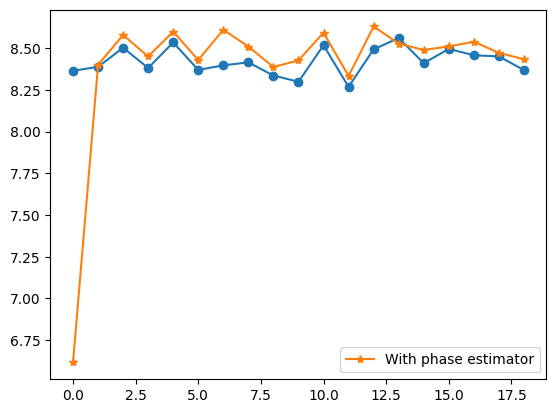

In [72]:
plt.plot(Q, '-o')
plt.plot(Q2, '-*', label='With phase estimator')

plt.legend()

In [28]:
np.mean(Q[3:])

7.469257

# Train MetaOpt (torch)

In [75]:
import h5py
import torch, numpy as np, matplotlib.pyplot as plt
from src.TorchSimulation.receiver import BER
from src.TorchDSP.loss import Qsq
from src.TorchSimulation.utils import show_symb
from src.TorchDSP.dataloader import MyDataset
from torch.utils.data import DataLoader
from src.TorchDSP.dsp import ADF
from src.TorchDSP.core import TorchSignal, TorchTime


def get_grp(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000, tag=',method=frequency cut'):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key][f'Rx(sps=2,chid=0{tag})']
        
def get_signal(f, Nch, Rs, Pch, Nsymb, NF, SF, L=2000):
    for key in f.keys():
        if f[key].attrs['Nch'] == Nch and f[key].attrs['Rs(GHz)'] == Rs and f[key].attrs['Pch(dBm)'] == Pch and f[key]['SymbTx'].shape[1] == Nsymb and f[key].attrs['NF(dB)'] == NF and f[key].attrs['freqspace(Hz)']/1e9 / f[key].attrs['Rs(GHz)'] == SF and f[key].attrs['distance(km)'] == L:
            return f[key]
        

def Q_path(Rx, Tx, Ntest=10000, stride=10000):
    Q = []
    for t in  np.arange(0, Rx.shape[-2] - Ntest, stride):
        Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))
    return Q

from src.JaxSimulation.dsp import BPS, bps, ddpll, cpr, mimoaf, MetaMIMO
import src.JaxSimulation.adaptive_filter as af, jax
from src.JaxSimulation.core import MySignal, SigTime
from src.JaxSimulation.MetaOptimizer import *

train_data = MyDataset('dataset_A800/train.h5', Nch=[21], Rs=[40], Pch=[0],Nmodes=2,
                        window_size=400, strides=400-15, Nwindow=200, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
train_loader = DataLoader(train_data, batch_size=20, shuffle=True)

test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0],Nmodes=2,
                        window_size=400, strides=400-15, Nwindow=100, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)
for Rx, Tx, info in test_loader:
    print(Rx.shape, Tx.shape, info.shape)
    break

const = np.unique(Tx)

signal = TorchSignal(val=Rx, t=TorchTime(0,0,2))
truth = TorchSignal(val=Tx, t=TorchTime(0,0,1))

torch.Size([1, 800, 2]) torch.Size([1, 400, 2]) torch.Size([1, 4])


In [76]:
model = ADF(method='metagrutest', taps=32, Nmodes=2, batch_size=20, lead_symbols=2000, mode='train', meta_args={'step_max':5e-2, 'hidden_dim':8, 'num_layers':2})
model = model.to('cuda:0')
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

In [77]:
for epoch in range(10):
    Ls = []
    for Rx1, Tx1, info1 in train_loader:
        rx = TorchSignal(val=Rx1, t=TorchTime(0,0,2)).to('cuda:0')
        tx = TorchSignal(val=Tx1, t=TorchTime(0,0,1)).to('cuda:0')
        info1 = info1.to('cuda:0')
        sig = model(rx, tx, info1)
        loss = torch.mean(torch.abs(sig.val - tx.val[:,sig.t.start:sig.t.stop])**2)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        model.detach_state()

        print(loss.item())

        Ls.append(loss.item())
    print(f'epoch {epoch}:',np.mean(Ls))

0.8369561433792114
0.4527834355831146
0.24000975489616394
0.12938205897808075
0.08006677031517029
0.05573074519634247
0.04365356266498566
0.038848549127578735
0.034739550203084946
0.032929353415966034
epoch 0: 0.1945099923759699
0.032623037695884705
0.03106687404215336
0.030966926366090775
0.03013659082353115
0.03120058961212635
0.03076028823852539
0.02992432378232479
0.03082432597875595
0.030384892597794533
0.0311407633125782
epoch 1: 0.030902861244976522
0.030101101845502853
0.030367176979780197
0.02972685731947422
0.030436592176556587
0.030946535989642143
0.030259041115641594
0.029737887904047966
0.029504865407943726
0.029902944341301918
0.030073756352066994
epoch 2: 0.03010567594319582
0.0306051354855299
0.029972247779369354
0.02972646988928318
0.029428258538246155
0.03029744140803814
0.029826097190380096
0.030286764726042747
0.030476026237010956
0.029856011271476746
0.029400765895843506
epoch 3: 0.029987521842122077
0.029832620173692703
0.03008320927619934
0.029750820249319077
0.0

In [78]:
test_data = MyDataset('dataset_A800/test.h5', Nch=[21], Rs=[40], Pch=[0],Nmodes=2,
                        window_size=500000, strides=400-15, Nwindow=1, truncate=0,
                        Tx_window=True, pre_transform='Rx_DBP16')
test_loader = DataLoader(test_data, batch_size=1, shuffle=True)

In [79]:
model.change_mode('test')
model.change_batchsize(1)
model.to('cpu')
ber = 0
for Rx1, Tx1, info1 in test_loader:
    rx = TorchSignal(val=Rx1, t=TorchTime(0,0,2)).to('cpu')
    tx = TorchSignal(val=Tx1, t=TorchTime(0,0,1)).to('cpu')
    info1 = info1.to('cpu')
    with torch.no_grad():
        sig = model(rx, tx, info1)

In [80]:
Q_meta = Q_path(sig.val.cpu().data[0], tx.val[0,7:-8].cpu().data)

/tmp/ipykernel_2107354/2093106935.py:26: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  Q.append(np.mean(BER(torch.tensor(Rx[t:t+Ntest]), torch.tensor(Tx[t:t+Ntest]))['Qsq']))


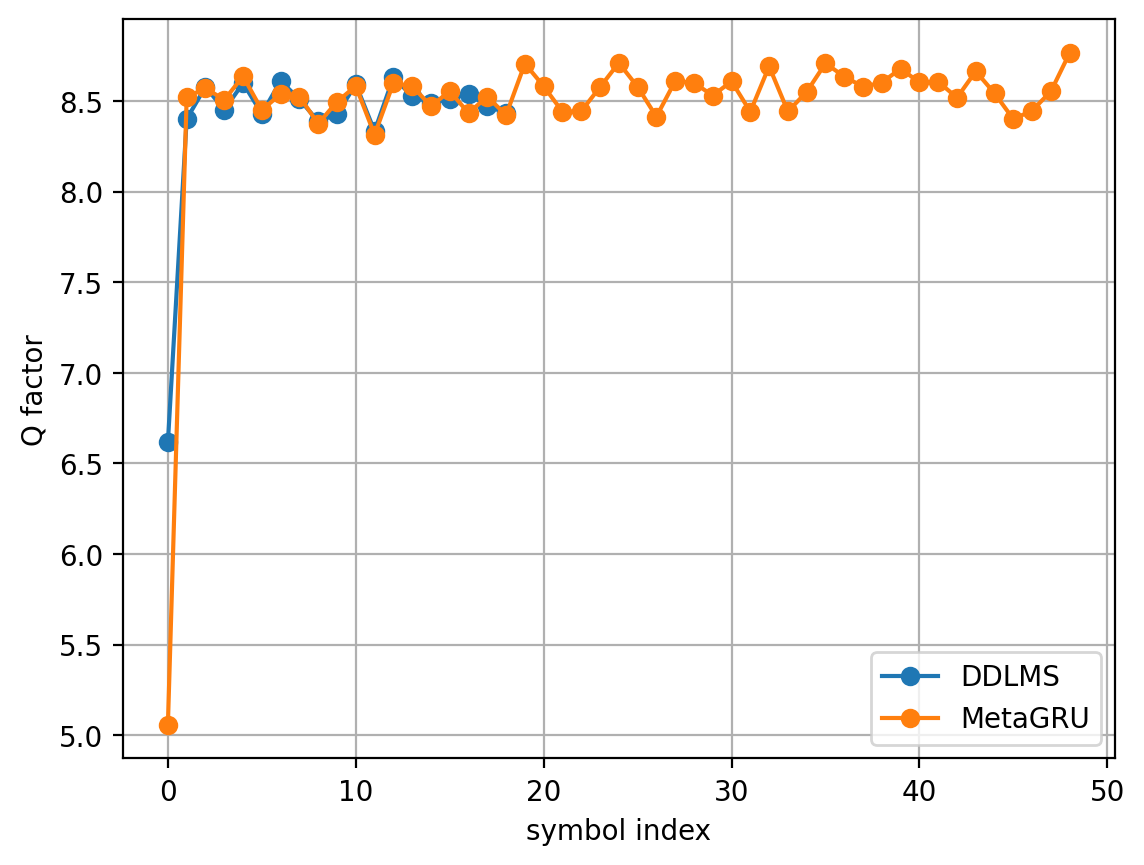

In [81]:
plt.figure(dpi=200)
plt.plot(Q2, '-o', label='DDLMS')
plt.plot(Q_meta, '-o', label='MetaGRU')
plt.legend()
# plt.ylim(8, 10)
# plt.yticks(np.arange(8, 10, 0.2))
plt.xlabel('symbol index')
plt.ylabel('Q factor')
plt.grid()

In [12]:
np.mean(Q_meta[5:10])

8.534943

In [13]:
np.mean(Q2[5:10])

8.530167

# small 

In [13]:
model.change_mode('test')
sig = model(signal, truth, info)
BER(sig.val[:,:], truth.val[:,7:-8][:,:])

{'BER': array([[0.01947605, 0.02845442]], dtype=float32),
 'SER': array([[0.07080155, 0.10271352]], dtype=float32),
 'Qsq': array([[6.2971077, 5.593386 ]], dtype=float32),
 'SNR': array([[13.506484, 12.637691]], dtype=float32)}

In [17]:
BER(sig.val[:,20000:], truth.val[:,7:-8][:,20000:])

{'BER': array([[0.00227671, 0.0028021 ]], dtype=float32),
 'SER': array([[0.00905679, 0.01120841]], dtype=float32),
 'Qsq': array([[9.057304, 8.849856]], dtype=float32),
 'SNR': array([[15.843673 , 15.7266865]], dtype=float32)}

## after traing

In [5]:
model.change_mode('test')
sig = model(signal, truth, info)
BER(sig.val[:,:], truth.val[:,7:-8][:,:])

{'BER': array([[0.0025322 , 0.00277604]], dtype=float32),
 'SER': array([[0.01007878, 0.01105415]], dtype=float32),
 'Qsq': array([[8.95218 , 8.859388]], dtype=float32),
 'SNR': array([[15.751697, 15.736883]], dtype=float32)}

In [8]:
BER(sig.val[:,10000:], truth.val[:,7:-8][:,10000:])

{'BER': array([[0.00231783, 0.00269301]], dtype=float32),
 'SER': array([[0.0092046, 0.0107387]], dtype=float32),
 'Qsq': array([[9.039775, 8.890237]], dtype=float32),
 'SNR': array([[15.800156, 15.78038 ]], dtype=float32)}